In [43]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [44]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [45]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_15s_0.05s.pt')
target_tensors = torch.load('target_tensors_15s_0.05s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([300, 22])
Shape of target tensor: torch.Size([3000])


In [46]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [47]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [58]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
model.load_state_dict(torch.load('model_weights_15s_0.05s.pt'))

num_epochs = 5000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)

        prev_loss = average_loss


Epoch 60, Loss: 0.3271:   1%|          | 60/5000 [00:12<17:30,  4.70it/s]


KeyboardInterrupt: 

In [59]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_15s_0.05s.pt')

In [60]:
total_absolute_error = 0
num_samples = len(test_targets)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input to the same device as the model
        predicted_value = model(test_data[i].unsqueeze(0)).item()
        actual_value = test_targets[i].item()
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


TypeError: len() of a 0-d tensor

In [ ]:
# get the average absolute error for the denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 37.52143478393555


In [ ]:
# get the median absolute error
absolute_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.07731940597295761


In [ ]:
# get the median absolute error for the denormalized values
absolute_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 8.738188743591309


In [ ]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 1.349299477603359


In [ ]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 17233.525390625


In [ ]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.26097801327705383, Predicted: -0.26000022888183594
Actual: -0.1850823014974594, Predicted: -0.1168978214263916
Actual: -0.25309640169143677, Predicted: -0.27024221420288086
Actual: -0.23960675299167633, Predicted: -0.18622732162475586
Actual: -0.25568556785583496, Predicted: -0.22321510314941406
Actual: -0.24677632749080658, Predicted: -0.1168978214263916
Actual: -0.17179828882217407, Predicted: -0.1168978214263916
Actual: -0.21251004934310913, Predicted: -0.04880881309509277
Actual: -0.20024289190769196, Predicted: -0.2767765522003174
Actual: -0.21079477667808533, Predicted: -0.1168978214263916
Actual: -0.2349291294813156, Predicted: -0.1887204647064209
Actual: -0.23565995693206787, Predicted: -0.18622732162475586
Actual: 0.1313663125038147, Predicted: 1.5730360746383667
Actual: -0.22256030142307281, Predicted: -0.1805124282836914
Actual: -0.15978288650512695, Predicted: -0.1168978214263916
Actual: -0.07996249943971634, Predicted: 0.9559433460235596
Actual: -0.2482136189937

In [ ]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")


Actual: 0.03391075134277344, Predicted: 0.14441490173339844
Actual: 8.611202239990234, Predicted: 16.317014694213867
Actual: 0.9246444702148438, Predicted: -1.0130748748779297
Actual: 2.4491653442382812, Predicted: 8.48179817199707
Actual: 0.6320323944091797, Predicted: 4.301654815673828
Actual: 1.6389026641845703, Predicted: 16.317014694213867
Actual: 10.112483978271484, Predicted: 16.317014694213867
Actual: 5.511478424072266, Predicted: 24.012039184570312
Actual: 6.89784049987793, Predicted: -1.7515487670898438
Actual: 5.705327987670898, Predicted: 16.317014694213867
Actual: 2.977804183959961, Predicted: 8.20003890991211
Actual: 2.8952102661132812, Predicted: 8.48179817199707
Actual: 44.37438201904297, Predicted: 207.30349731445312
Actual: 4.3756561279296875, Predicted: 9.127662658691406
Actual: 11.470394134521484, Predicted: 16.317014694213867
Actual: 20.491230010986328, Predicted: 137.5632781982422
Actual: 1.4764690399169922, Predicted: 2.9983673095703125
Actual: 10.543590545654297

In [ ]:
# calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")


# remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 252.25375673902676%
Standard Deviation of Percentage Errors: 17.525410558998875
Average Percentage Error (Without Top 2%): 74.01835632324219%
Standard Deviation of Percentage Errors (Without Top 2%): 17.700864440611067


In [ ]:
# calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")



Average Percentage Error (Denormalized): 940.8199462890625%
Standard Deviation of Percentage Errors (Denormalized): 34.73747253417969
Average Percentage Error (Without Top 2%, Denormalized): 74.01835632324219%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 35.074092864990234


In [ ]:
# calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")


median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 39.22632407883497%


In [ ]:
# calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")

Median Percentage Error (Denormalized): 184.70877408981323%


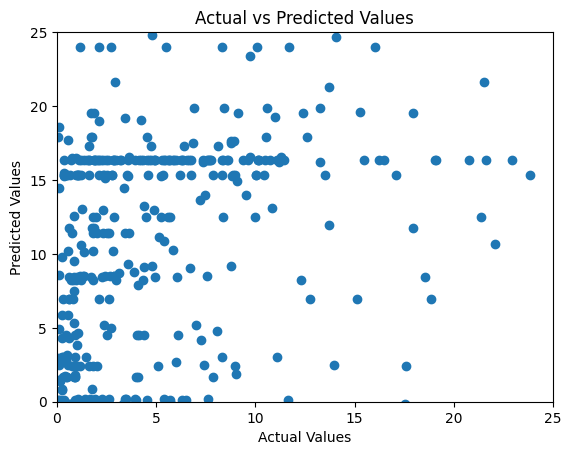

In [ ]:
# plot the denormalized values for the actual and predicted values on testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

